# Bitcoin

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.1f' % x)
df = pd.read_csv("./bitcoin.csv", index_col=0)
df.set_index(pd.to_datetime(df.index, unit='s'), inplace=True)
df.sort_index(inplace=True)

df2 = df['Price'].resample('8H').ohlc().fillna(method='ffill')
df2.head()

,open,high,low,close
Timestamp,,,,
2015-07-25 16:00:00,190001.0,190001.0,190001.0,190001.0
2015-07-26 00:00:00,190001.0,190001.0,190001.0,190001.0
2015-07-26 08:00:00,192990.0,193000.0,192990.0,193000.0
2015-07-26 16:00:00,193000.0,193000.0,193000.0,193000.0
2015-07-27 00:00:00,193000.0,193000.0,193000.0,193000.0


Crear un nuevo dataframe con los datos de la ultima semana, con un resample de 6 horas

In [2]:
import time
import dateutil
from datetime import datetime

lw_timestamp = time.time() - (60 * 60 * 24 * 30)
tz = dateutil.tz.tzlocal()
lw_dt = datetime.fromtimestamp(lw_timestamp, tz=tz)

lw_df = df.Price.resample('8H').ohlc().fillna(method='ffill')
lw_df = lw_df[lw_df.index > lw_dt]

lw_df.head()

,open,high,low,close
Timestamp,,,,
2018-01-25 16:00:00,6974755.6,7051410.8,6890000.0,6957996.0
2018-01-26 00:00:00,6972818.0,7108444.3,6925001.0,6930000.0
2018-01-26 08:00:00,6930000.0,6959000.0,6500000.0,6681010.0
2018-01-26 16:00:00,6804987.0,7004906.1,6750001.0,6907349.3
2018-01-27 00:00:00,6895124.7,6978831.0,6750001.0,6923078.8


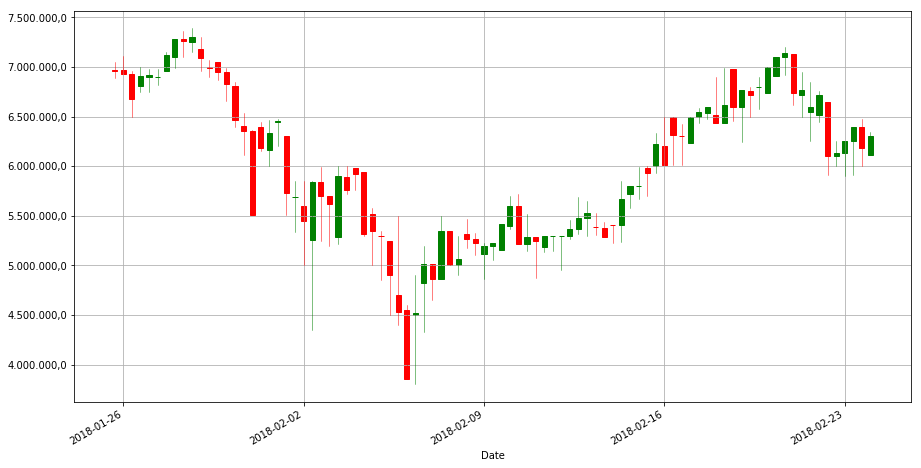

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates
from utils import split_thousands

lw_df=lw_df.reset_index()
lw_df['Timestamp'] = lw_df['Timestamp'].map(mdates.date2num)
lw_df.head()

fig, ax1 = plt.subplots(figsize=(15, 8))
ax1.xaxis_date()
plt.xlabel("Date")
ax1.get_yaxis().set_major_formatter(FuncFormatter(split_thousands))

candlestick_ohlc(ax1, lw_df.values, colorup='g', colordown='r')
fig.autofmt_xdate()
plt.grid()
plt.show()

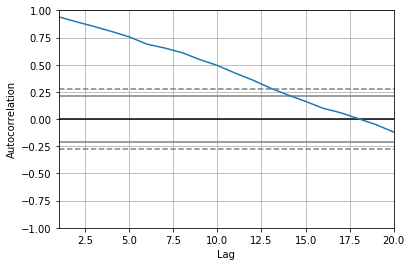

In [4]:
from utils import autocorrelation_plot

df3 = df['Price'].resample('1D').mean().dropna()
#autocorrelation_plot(df3, 20)
open_series = lw_df.open
autocorrelation_plot(open_series, 20);

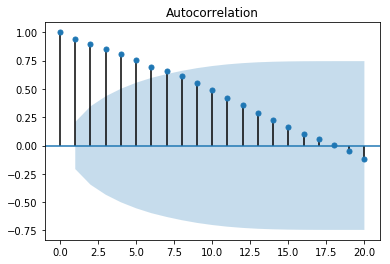

In [5]:
from statsmodels.graphics.tsaplots import plot_acf

df4 = df ['Price'].resample('6H').mean().fillna(method='ffill')
df4_series = lw_df.open
plot_acf(df4_series, lags=20);

In [6]:
mean_df = pd.DataFrame(df4)
window_short = 40
window_medium = 80
mean_df['ma_short'] = df4.rolling(window=window_short).mean()
mean_df['max'] = df4.rolling(window=window_short).max()
mean_df['min'] = df4.rolling(window=window_short).min()
mean_df['ma_medium'] = df4.rolling(window=window_medium).mean()
mean_df.tail()

,Price,ma_short,max,min,ma_medium
Timestamp,,,,,
2018-02-23 00:00:00,6046221.7,6329864.8,7155439.2,5332107.2,5767244.4
2018-02-23 06:00:00,6108234.3,6347514.1,7155439.2,5332107.2,5774999.7
2018-02-23 12:00:00,6312306.6,6371468.9,7155439.2,5332107.2,5781717.4
2018-02-23 18:00:00,6218125.1,6393619.3,7155439.2,5337767.4,5786263.4
2018-02-24 00:00:00,6260737.6,6416693.6,7155439.2,5391286.1,5791427.8


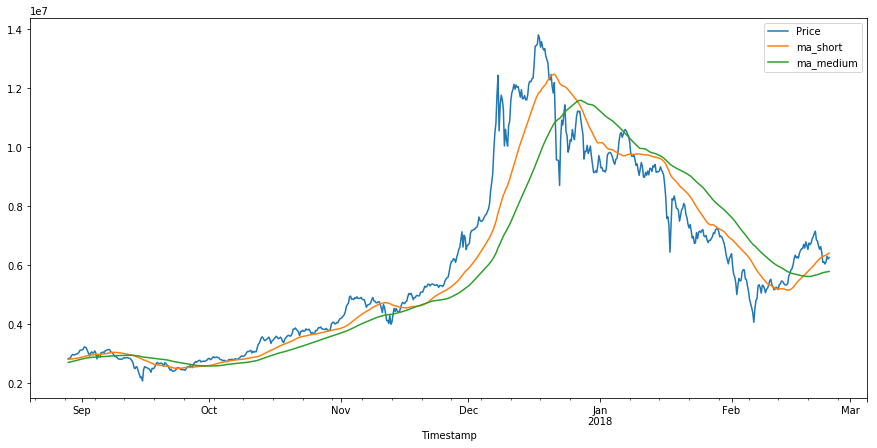

In [7]:
from utils import get_diff_datetime
date_break = get_diff_datetime(60 * 60 * 24 * 30 * 6)
mean_df = mean_df[mean_df.index > date_break]
mean_df[['Price', 'ma_short', 'ma_medium']].plot(figsize=(15,7));

In [8]:
from preprocesor import MinMaxNormalizeSlidingWindow

scaler = MinMaxNormalizeSlidingWindow()
ndf = scaler.fit_transform(mean_df.Price, window=60)
ndf.tail()

Timestamp
2018-02-23 00:00:00   0.5
2018-02-23 06:00:00   0.5
2018-02-23 12:00:00   0.6
2018-02-23 18:00:00   0.6
2018-02-24 00:00:00   0.5
Freq: 6H, Name: Price, dtype: float64

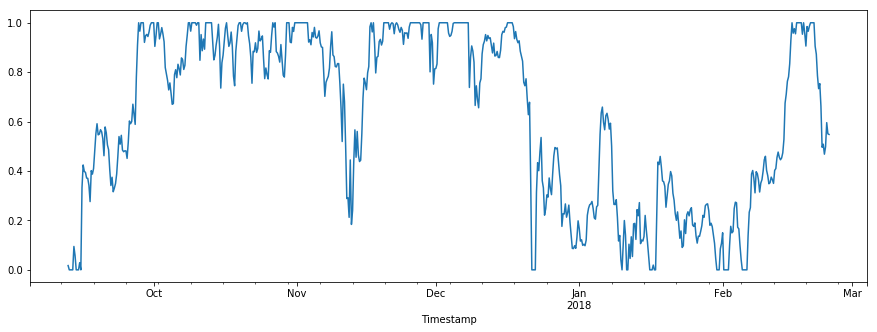

In [9]:
ndf.plot(figsize=(15,5));

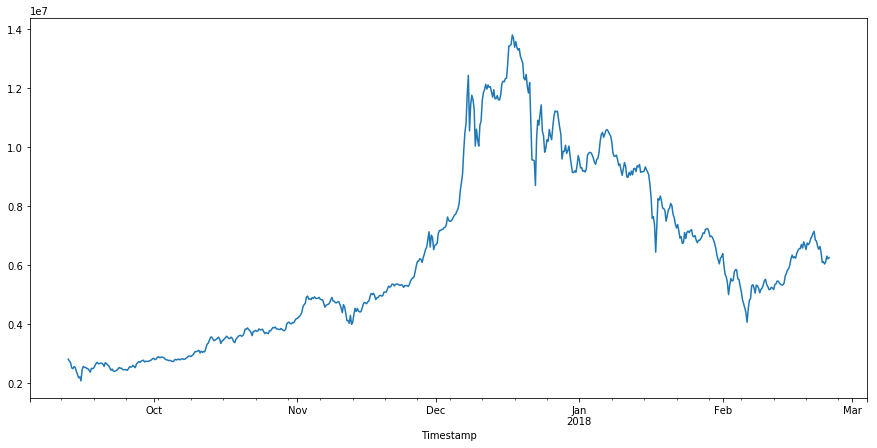

In [10]:
ndf2 = scaler.inverse_transformation(ndf)
ndf2.plot(figsize=(15,7));